In [1]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import jax.random as random
import numpyro
numpyro.set_host_device_count(2)
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS, SVI, Trace_ELBO, Predictive, init_to_mean
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from sklearn.model_selection import train_test_split
import pickle
import os
import time
from sklearn.utils import compute_sample_weight

In [2]:
train = pd.read_csv('data/interim/train.csv')  # Ensure this file exists
X = train.drop('label', axis=1)
y = train['label']

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1000, random_state=123, stratify=y)

In [4]:
X_train_df = pd.DataFrame(X_train, columns = X.columns)
y_train_df = pd.DataFrame(y_train, columns = ['label'])

X_val_df = pd.DataFrame(X_val, columns = X.columns)
y_val_df = pd.DataFrame(y_val, columns = ['label'])

In [5]:
train_df = pd.concat([y_train_df, X_train_df], axis=1)
val_df = pd.concat([y_val_df, X_val_df], axis=1)

In [6]:
train_df.to_csv("data/processed/train.csv", index=False)
val_df.to_csv("data/processed/validation.csv", index=False)

In [7]:
X_train, X_val = jnp.array(X_train), jnp.array(X_val)
y_train, y_val = jnp.array(y_train), jnp.array(y_val)

In [8]:
widths = [5, 10, 14]
precisions = [0.5, 1.0, 2.0]  # Low, Moderate, High expected precision
inference_methods = ['mcmc', 'vi']
vi_guides = {
    'AutoDiag': AutoDiagonalNormal,
    'AutoMult': AutoMultivariateNormal
}
mcmc_kernels = {
    'NUTS': NUTS
}

In [9]:
prec_prior_map = {
    0.5: (1.0, 2.0),  
    1.0: (6.0, 6.0),   
    2.0: (4.0, 2.0)   
}

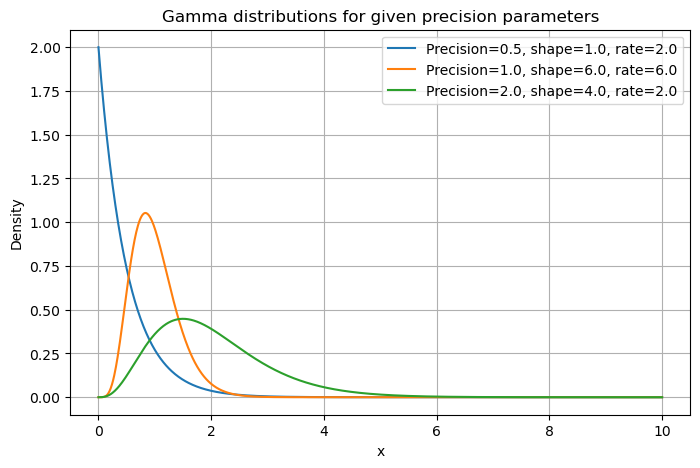

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import gamma
x = np.linspace(0, 10, 1000)  # range to plot

plt.figure(figsize=(8, 5))

for precision, (shape, rate) in prec_prior_map.items():
    # scipy gamma takes shape (a) and scale = 1/rate
    scale = 1 / rate
    y = gamma.pdf(x, a=shape, scale=scale)
    plt.plot(x, y, label=f'Precision={precision}, shape={shape}, rate={rate}')

plt.title('Gamma distributions for given precision parameters')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
#weights = compute_sample_weight(class_weight='balanced', y=y_train)
#sample_weights = jnp.array(weights / weights.sum())
#sample_weights = jnp.array(weights)

In [ ]:
def bnn_model(X, y=None, hidden_dim=10, prec_level=1.0):
    n, m = X.shape
    alpha, beta = prec_prior_map[prec_level]
    prec_nn = numpyro.sample('prec_nn', dist.Gamma(alpha, beta))

    with numpyro.plate('l1_hidden', hidden_dim):
        b1 = numpyro.sample('nn_b1', dist.Normal(0.0, jnp.sqrt(2.0 / (prec_nn * (m + 1)))))
        with numpyro.plate('l1_feat', m):
            w1 = numpyro.sample('nn_w1', dist.Normal(0.0, jnp.sqrt(2.0 / (prec_nn * (m + 1)))))

    with numpyro.plate('l2_hidden', hidden_dim):
        w2 = numpyro.sample('nn_w2', dist.Normal(0.0, jnp.sqrt(2.0 / (prec_nn * (hidden_dim + 1)))))
    b2 = numpyro.sample('nn_b2', dist.Normal(0.0, jnp.sqrt(2.0 / (prec_nn * (hidden_dim + 1)))))

    hidden = jnp.maximum(X @ w1 + b1, 0)
    logits = hidden @ w2 + b2

    with numpyro.plate('data', n):
        numpyro.sample('obs', dist.Bernoulli(logits=logits), obs=y)

In [13]:
os.makedirs('results/bnn/', exist_ok=True)
os.makedirs('results/bnn/elbo/', exist_ok=True)
os.makedirs('results/bnn/extra/', exist_ok=True)

In [14]:
experiment_logs = []
key = random.PRNGKey(123)

for method in inference_methods:
    if method == 'mcmc':
        for kernel_name, kernel_cls in mcmc_kernels.items():
            for width in widths:
                for prec in precisions:
                    
                    id = f'{method}_{kernel_name}_w{width}_p{prec}'
                    print(f'Running {id}')
                    key, subkey = random.split(key)
                    start_time = time.time()
                    
                    try:
                        kernel = kernel_cls(bnn_model, init_strategy=init_to_mean)
                        mcmc = MCMC(kernel, num_warmup=250, num_samples=500, num_chains=2)
                        mcmc.run(subkey, X_train, y_train, hidden_dim=width, prec_level=prec)
                        results = mcmc.get_samples(group_by_chain=True)
                        
                        with open(f'results/bnn/{id}_samples.pkl', 'wb') as f:
                            pickle.dump(results, f)

                        extras = mcmc.get_extra_fields()
                        with open(f'results/bnn/extra/{id}_extra.pkl', 'wb') as f:
                            pickle.dump(extras, f)
                            
                        duration = time.time() - start_time
                        
                        experiment_logs.append({
                            'id': id,
                            'method': method,
                            'kernel': kernel_name,
                            'width': width,
                            'precision_prior': prec,
                            'duration_seconds': round(duration, 2),
                            'status': 'success'
                        })
                        
                    except Exception as e:
                        
                        duration = time.time() - start_time
                        
                        experiment_logs.append({
                            'id': id,
                            'method': method,
                            'kernel': kernel_name,
                            'width': width,
                            'precision_prior': prec,
                            'duration_seconds': round(duration, 2),
                            'status': f'error: {str(e)}'
                        })
                        
                        print(f'Experiment {id} failed: {e}')

    else:  # method == 'vi'
        for guide_name, guide_cls in vi_guides.items():
            for width in widths:
                for prec in precisions:
                    
                    id = f'{method}_{guide_name}_w{width}_p{prec}'
                    print(f'Running {id}')
                    key, subkey = random.split(key)
                    start_time = time.time()
                    
                    try:
                        guide = guide_cls(bnn_model)
                        svi = SVI(bnn_model, guide, numpyro.optim.Adam(1e-3), Trace_ELBO())
                        svi_result = svi.run(subkey, 2000, X_train, y_train, hidden_dim=width, prec_level=prec)
                        elbo_vals = svi_result.losses
                        results = guide.sample_posterior(random.PRNGKey(1), svi_result.params, sample_shape=(1000,))
                        
                        with open(f'results/bnn/{id}_samples.pkl', 'wb') as f:
                            pickle.dump(results, f)

                        with open(f'results/bnn/elbo/{id}_elbo.pkl', 'wb') as f:
                            pickle.dump(elbo_vals, f)
                            
                        duration = time.time() - start_time
                        
                        experiment_logs.append({
                            'id': id,
                            'method': method,
                            'guide': guide_name,
                            'width': width,
                            'precision_prior': prec,
                            'duration_seconds': round(duration, 2),
                            'status': 'success'
                        })
                        
                    except Exception as e:
                        
                        duration = time.time() - start_time
                        
                        experiment_logs.append({
                            'id': id,
                            'method': method,
                            'guide': guide_name,
                            'width': width,
                            'precision_prior': prec,
                            'duration_seconds': round(duration, 2),
                            'status': f'error: {str(e)}'
                        })
                        
                        print(f'Experiment {id} failed: {e}')

log_df = pd.DataFrame(experiment_logs)
log_df.to_csv('results/experiment_log.csv', index=False)
print('Experiment summary saved to results/experiment_log.csv')

Running mcmc_NUTS_w5_p0.5


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Running mcmc_NUTS_w5_p1.0


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Running mcmc_NUTS_w5_p2.0


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Running mcmc_NUTS_w10_p0.5


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Running mcmc_NUTS_w10_p1.0


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Running mcmc_NUTS_w10_p2.0


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Running mcmc_NUTS_w14_p0.5


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Running mcmc_NUTS_w14_p1.0


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Running mcmc_NUTS_w14_p2.0


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Running vi_AutoDiag_w5_p0.5


100%|██████████████████| 2000/2000 [00:12<00:00, 155.83it/s, init loss: 249484.2656, avg. loss [1901-2000]: 11417.4248]


Running vi_AutoDiag_w5_p1.0


100%|████████████████████| 2000/2000 [00:14<00:00, 137.93it/s, init loss: 62597.3711, avg. loss [1901-2000]: 9809.7334]


Running vi_AutoDiag_w5_p2.0


100%|███████████████████| 2000/2000 [00:14<00:00, 138.64it/s, init loss: 228646.0938, avg. loss [1901-2000]: 9962.6514]


Running vi_AutoDiag_w10_p0.5


100%|███████████████████| 2000/2000 [00:26<00:00, 75.87it/s, init loss: 203723.7500, avg. loss [1901-2000]: 10067.4766]


Running vi_AutoDiag_w10_p1.0


100%|████████████████████| 2000/2000 [00:26<00:00, 75.85it/s, init loss: 238856.9062, avg. loss [1901-2000]: 9231.7686]


Running vi_AutoDiag_w10_p2.0


100%|████████████████████| 2000/2000 [00:24<00:00, 82.64it/s, init loss: 168058.4688, avg. loss [1901-2000]: 9053.4854]


Running vi_AutoDiag_w14_p0.5


100%|████████████████████| 2000/2000 [00:25<00:00, 77.07it/s, init loss: 124398.1016, avg. loss [1901-2000]: 8654.5811]


Running vi_AutoDiag_w14_p1.0


100%|████████████████████| 2000/2000 [00:26<00:00, 76.74it/s, init loss: 225865.1406, avg. loss [1901-2000]: 8914.4697]


Running vi_AutoDiag_w14_p2.0


100%|███████████████████| 2000/2000 [00:27<00:00, 73.36it/s, init loss: 413597.4688, avg. loss [1901-2000]: 10275.6748]


Running vi_AutoMult_w5_p0.5


100%|████████████████████| 2000/2000 [00:11<00:00, 175.88it/s, init loss: 81600.0781, avg. loss [1901-2000]: 8668.8027]


Running vi_AutoMult_w5_p1.0


100%|████████████████████| 2000/2000 [00:09<00:00, 207.10it/s, init loss: 42866.3086, avg. loss [1901-2000]: 8350.2520]


Running vi_AutoMult_w5_p2.0


100%|██████████████████| 2000/2000 [00:09<00:00, 207.63it/s, init loss: 144605.6719, avg. loss [1901-2000]: 12416.2109]


Running vi_AutoMult_w10_p0.5


100%|███████████████████| 2000/2000 [00:14<00:00, 134.64it/s, init loss: 448189.4375, avg. loss [1901-2000]: 9807.7705]


Running vi_AutoMult_w10_p1.0


100%|███████████████████| 2000/2000 [00:14<00:00, 135.02it/s, init loss: 339176.7188, avg. loss [1901-2000]: 9891.0752]


Running vi_AutoMult_w10_p2.0


100%|███████████████████| 2000/2000 [00:14<00:00, 138.85it/s, init loss: 265598.5312, avg. loss [1901-2000]: 8543.7021]


Running vi_AutoMult_w14_p0.5


100%|████████████████████| 2000/2000 [00:19<00:00, 103.73it/s, init loss: 87231.5156, avg. loss [1901-2000]: 8868.4932]


Running vi_AutoMult_w14_p1.0


100%|███████████████████| 2000/2000 [00:19<00:00, 102.22it/s, init loss: 174379.3594, avg. loss [1901-2000]: 8765.4971]


Running vi_AutoMult_w14_p2.0


100%|███████████████████| 2000/2000 [00:19<00:00, 102.50it/s, init loss: 238777.8594, avg. loss [1901-2000]: 9080.0635]


Experiment summary saved to results/experiment_log.csv
